In [546]:
##### Fall 2019 HW2 Problem 3 Multi-Class Linear Classification with Softmax #####

# The data points are in 2D, so you can easily visualize them in a 2D plane to help you understand
# the distribution of those data points. We have 4 classes in total, which are denoted by 0, 1, 2, 3 in Y for each class.

# TO-DO #

# Use the following reference code to load the training and testing data
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

svpath = './Q3_data.npz'
data = np.load(svpath)

# X, array of shape [n_samples, n_features]
# Y, array of shape [n_samples]
X = data['X']
Y = data['Y']

# 3a. Single Layer

In [547]:
class LinearModel:
    def __init__(self, a, b): #set the iterations and the descent rate
        super().__init__() 
        self.epochs = a
        self.rate = b
    def forward(self, X, W, b):
        return np.add(np.dot(W, X),  b)
    def train(self, X: np.ndarray, y: np.ndarray):
        classes = np.unique(y).size 
        W = np.zeros([classes, X.shape[0]]) 
        b = np.zeros([classes, 1])
        one_hot_y = np.zeros([classes, y.shape[0]]) #one hot encoding of y
        losses = np.zeros(self.epochs)
        acc = np.zeros(self.epochs)
        
        for i in range(y.shape[0]):
            one_hot_y[int(y[i])][i] = 1
        
        for i in range(self.epochs):
            y_hat = self.forward(X, W, b)
            outputs = self.softmax_func(y_hat)
            w_grad, b_grad = self.grad(X, one_hot_y, b, outputs)
            W -= self.rate*w_grad
            b -= self.rate*b_grad
            losses[i] = self.loss(outputs, one_hot_y)
            acc[i] = self.classification_accuracy(W, X, b, y)
        self.plot(losses, acc)
        return W, b
            
    def softmax_func(self, y_hat):
        return np.exp(y_hat) / np.sum(np.exp(y_hat), axis=0)
        
    def predict(self, W:np.ndarray, X: np.ndarray, b:np.ndarray):
        y_hat = self.forward(X, W, b)
        outputs = self.softmax_func(y_hat)
        return np.argmax(outputs, axis = 0)

    def loss(self, outputs: np.ndarray, y: np.ndarray):
        # Using KL divergence as loss, but entropy is 0 because the entropy of the true label is 0, thus we are only left
        # with the cross entropy calculated below
        return -(np.sum(y*np.log(outputs)))

    def grad(self, X: np.ndarray, y: np.ndarray, b: np.ndarray, outputs): 
        # Use backpropagation dE/dw = dE/dy dy/dw, where E is the outputed cost, y is the prediction
        samples = X.shape[0]
        grad_e_y = -(y - outputs) # y = WX + b
        grad_y_w = X
        grad_e_w = (1/samples) * np.dot(grad_e_y, np.transpose(X)) #average across all samples
        grad_y_b = 1
        grad_e_b = (1/samples) * np.sum(grad_e_y, axis=1) #average across all samples
        return grad_e_w, grad_e_b.reshape(grad_e_b.shape[0], 1)
    
    def classification_accuracy(self, W:np.ndarray, X: np.ndarray, b:np.ndarray, y: np.ndarray):
        pred = self.predict(W, X, b)
        samples = y.shape[0]
        count = 0
        for i in range(samples):
            if pred[i] == y[i]:
                count = count + 1
        return count/samples
    
    def plot(self, loss:np.ndarray, acc:np.ndarray):
        
        plt.plot(acc)
        plt.title('Accuracy per epoch')
        plt.xlabel('Epochs')
        plt.ylabel('%Accuracy')
        plt.show()
        
        plt.plot(loss)
        plt.title('Loss per epoch')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.show()
        
        print('Accuracy: ' + str(acc[-1]*100) + '%')

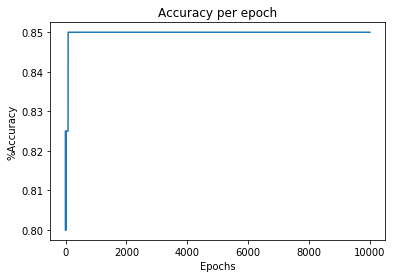

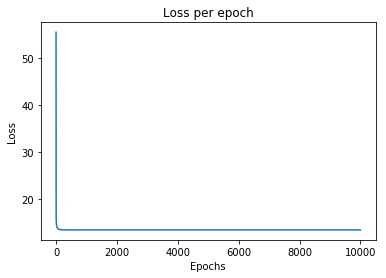

Accuracy: 85.0%


In [548]:
a = LinearModel(10000, 0.1)
w_single, b_single = a.train(np.transpose(X), Y) #input should be features x Examples

# 3b. Multi Layer

In [549]:
class MultiLinearModel:
    
    def __init__(self, a, b): #set the iterations and the descent rate
        super().__init__() 
        self.epochs = a
        self.rate = b
    def forward(self, X, W, W2, b, b2):
        layer1Out = np.add(np.dot(W, X),  b)
        activatedLayer = self.relu_func(layer1Out)
        layer2Out = np.add(np.dot(W2, activatedLayer),  b2)
        y_hat = self.softmax_func(layer2Out)
        return y_hat, activatedLayer
    
    def train(self, X: np.ndarray, y: np.ndarray):
        classes = np.unique(y).size
        W = np.random.randn(classes, X.shape[0]) 
        b = np.random.randn(classes, 1) 
        W2 = np.random.randn(classes, classes)
        b2 = np.random.randn(classes, 1)
        one_hot_y = np.zeros([classes, y.shape[0]]) #one hot encoding of y
        losses = np.zeros(self.epochs)
        acc = np.zeros(self.epochs)
        
        for i in range(y.shape[0]):
            one_hot_y[int(y[i])][i] = 1
        
        for i in range(self.epochs):
            #one forward and back pass
            y_hat, activated_layer = self.forward(X, W, W2, b, b2)
            grads = self.grad(X, one_hot_y, b, y_hat, activated_layer, W2)
            W -= self.rate*grads[0]
            b -= self.rate*grads[1]
            W2 -= self.rate*grads[2]
            b2 -= self.rate*grads[3]
            losses[i] = self.loss(y_hat, one_hot_y)
            acc[i] = self.classification_accuracy(W, X, b, y, W2, b2)
        self.plot(losses, acc)
        return W, W2, b, b2
            
    def softmax_func(self, y_hat):
        return np.exp(y_hat) / np.sum(np.exp(y_hat), axis=0)
    
    def relu_func(self, inp):
        return np.maximum(inp, 0)
    def predict(self, W:np.ndarray, X: np.ndarray, b:np.ndarray, W2, b2):
        outputs = self.forward(X, W, W2, b, b2)[0]
        return np.argmax(outputs, axis=0)
    def loss(self, outputs: np.ndarray, y: np.ndarray):
        # Using KL divergence as loss, but entropy is 0 because the entropy of the true label is 0, thus we are only left
        # with the cross entropy calculated below
        outputs[outputs == 0] = 0.00001
        return -(np.sum(y*np.log(outputs)))

    def grad(self, X: np.ndarray, y: np.ndarray, b: np.ndarray, outputs, activation, W2):
        
        samples = X.shape[1] #40
        # second layer backprop
        grad_e_y = -(y - outputs) # y = WX + b
        grad_y_w2 = activation
        grad_e_w2 = (1/samples) * np.dot(grad_e_y, np.transpose(activation)) #average across all samples
        grad_y_b2 = 1
        grad_e_b2 = (1/samples) * np.sum(grad_e_y, axis=1) #average across all samples
        relu_derv = grad_e_y.copy()
        relu_derv[relu_derv < 0] = 0
        relu_derv[relu_derv >= 0] = 1

        grad_e_y2 = np.multiply(relu_derv, np.transpose(np.dot(np.transpose(grad_e_y), W2))) #chain rule
        grad_y2_w1 = X
        grad_e_w1 = (1/samples) * np.dot(grad_e_y2, np.transpose(X))
        grad_y2_b1 = 1
        grad_e_b1 = (1/samples) * np.sum(grad_e_y2, axis=1)
        return grad_e_w1, grad_e_b1.reshape(grad_e_b1.shape[0], 1), grad_e_w2, grad_e_b2.reshape(grad_e_b2.shape[0], 1)
    
    def classification_accuracy(self, W:np.ndarray, X: np.ndarray, b:np.ndarray, y: np.ndarray, W2, b2):
        pred = self.predict(W, X, b, W2, b2)
        samples = y.shape[0]
        count = 0
        for i in range(samples):
            if pred[i] == y[i]:
                count = count + 1
        return count/samples
    
    def plot(self, loss:np.ndarray, acc:np.ndarray):
        
        plt.plot(acc)
        plt.title('Accuracy per epoch')
        plt.xlabel('Epochs')
        plt.ylabel('%Accuracy')
        plt.show()
        
        plt.plot(loss)
        plt.title('Loss per epoch')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.show()
        
        print('Accuracy: ' + str(acc[-1]*100) + '%')

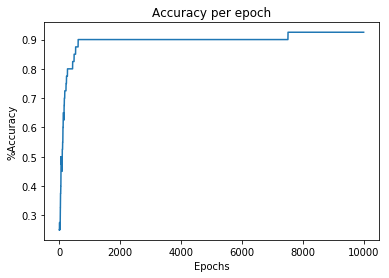

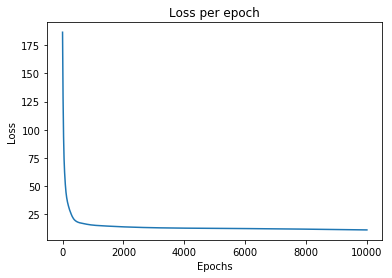

Accuracy: 92.5%


In [553]:
b = MultiLinearModel(10000, 0.01)
w_multi, w2_multi, b_multi, b2_multi = b.train(np.transpose(X), Y)

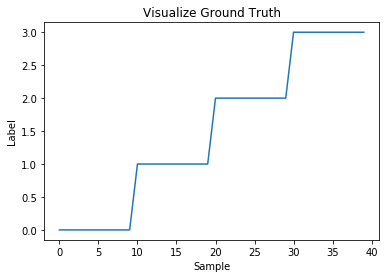

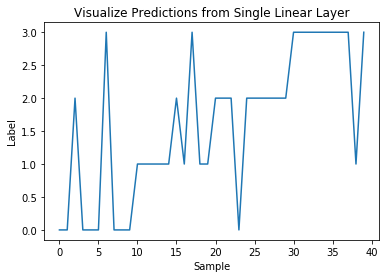

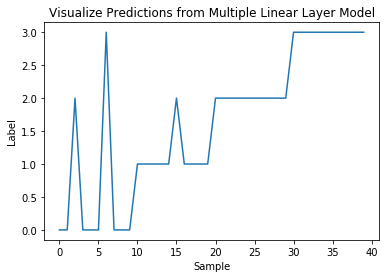

In [559]:
# Printing out the label visualizations
plt.plot(Y)
plt.title('Visualize Ground Truth')
plt.xlabel('Sample')
plt.ylabel('Label')
plt.show()

pred_single = a.predict(w_single, np.transpose(X), b_single) #predictions from the single linear layer model
plt.plot(pred_single)
plt.title('Visualize Predictions from Single Linear Layer')
plt.xlabel('Sample')
plt.ylabel('Label')
plt.show()

pred_multi = b.predict(w_multi, np.transpose(X), b_multi, w2_multi, b2_multi) #predictions from the Multiple linear layer model
plt.plot(pred_multi)
plt.title('Visualize Predictions from Multiple Linear Layer Model')
plt.xlabel('Sample')
plt.ylabel('Label')
plt.show()